<a href="https://colab.research.google.com/github/Luke-zm/coursera_learning/blob/main/Economic_Dispatch_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For colab, install the necessary kits
!pip install pyomo
!apt-get install -y -qq glpk-utils
!apt install coinor-libipopt-dev
# !apt install coinor-libipopt-dev
# !pip install ipopt
!pip install ipopt
!wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
coinor-libipopt-dev is already the newest version (3.11.9-2.2build5).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [ ]:
# Import the solver tools
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

# Import the processing tool
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# Note: This is an econmic dispatch problem
# For all generating units, there will be an input output curve...
# This curve is approximated by:
# fuel_cost = alpha*Power_gen**2 + beta*power_gen + gamma
# This a quadratic function

# Below is the table of such an equation
generation_dict = {"generator": ['G1', 'G2', 'G3', 'G4', 'G5'],
                   "a": [3.00, 4.05, 4.05, 3.99, 3.88],
                   "b": [20.00, 18.07, 15.55, 19.21, 26.18],
                   "c": [100.00, 98.87, 104.26, 107.21, 95.31],
                   "pmin": [28, 90, 68, 76, 19],
                   "pmax": [206, 284, 189, 266, 53]}
generation_df = pd.DataFrame(generation_dict)
generation_df

,generator,a,b,c,pmin,pmax
0,G1,3.00,20.00,100.00,28,206
1,G2,4.05,18.07,98.87,90,284
2,G3,4.05,15.55,104.26,68,189
3,G4,3.99,19.21,107.21,76,266
4,G5,3.88,26.18,95.31,19,53


Economic dispatch problem:  
$$  
\\min_{DV} \sum_g a_g \times P_g^2 + b_g \times P_g + c_g    
\\subject~to:~    
\\ \sum_g P_g \geq Load   
\\ P_g^{min} \leq P_g \leq P_g^{max}    
$$

In [ ]:
# Prepare the model
# Initialize an AbstractModel()
model = pyo.AbstractModel()
# Initialize the indices
model.g = pyo.Set(initialize=['G1', 'G2', 'G3', 'G4', 'G5'])
# model.g = pyo.RangeSet(len(generation_df["generator"]))

In [ ]:
model.g

In [ ]:
generation_df.loc[generation_df['generator']=='G1','pmin']

0    28
Name: pmin, dtype: int64

In [ ]:
# The model need to create different upper and lower bounds for Pg
# For this purpose, a function is needed
# All functions pyomo need to have model object passed in
# since that is where things are being defined
def bound_Pg(model, g):
  pmin = generation_df.loc[generation_df['generator']==g,'pmin']
  pmax = generation_df.loc[generation_df['generator']==g,'pmax']
  return (float(pmin), float(pmax))
# Initialize the Variable Pg with dynamic bounds using the above function
model.Pg = pyo.Var(model.g, bounds=bound_Pg, initialize=0, within=pyo.NonNegativeReals)

In [ ]:
# Define the loads
# This is a parameter and the demand is considered to be 300 MW
model.Load = pyo.Param(initialize=300, within=pyo.NonNegativeReals)

In [ ]:
# Define the constraints for economic dispatch

# Define a function for the economic dispatch
def power_balance(model, g):
  return sum(model.Pg[g] for g in model.g) >= model.Load
model.power_balance = pyo.Constraint(rule=power_balance)

In [ ]:
type(generation_df.loc[generation_df['generator']=='G1','a'])

pandas.core.series.Series

In [ ]:
# Define the objective function
def objective_func(model):
  return sum(float(generation_df.loc[generation_df['generator']=='G1','a']) * model.Pg[g] * model.Pg[g] +
             float(generation_df.loc[generation_df['generator']=='G1','b']) * model.Pg[g] +
             float(generation_df.loc[generation_df['generator']=='G1','c']) for g in model.g)

# Use the objective function
model.objective_func = pyo.Objective(rule=objective_func, sense=pyo.minimize)

In [ ]:
result = SolverFactory('ipopt')
instance = model.create_instance()
results = result.solve(instance)

In [ ]:
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1
  Number of variables: 5
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.012676000595092773
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


In [ ]:
for g in instance.g:
  print(g, pyo.value(instance.Pg[g]))


G1 32.999999670027336
G2 90.0
G3 68.0
G4 76.0
G5 32.99999966995517


In [ ]:
Total = sum(pyo.value(instance.Pg[g]) for g in instance.g)
print(Total)

299.99999933998254


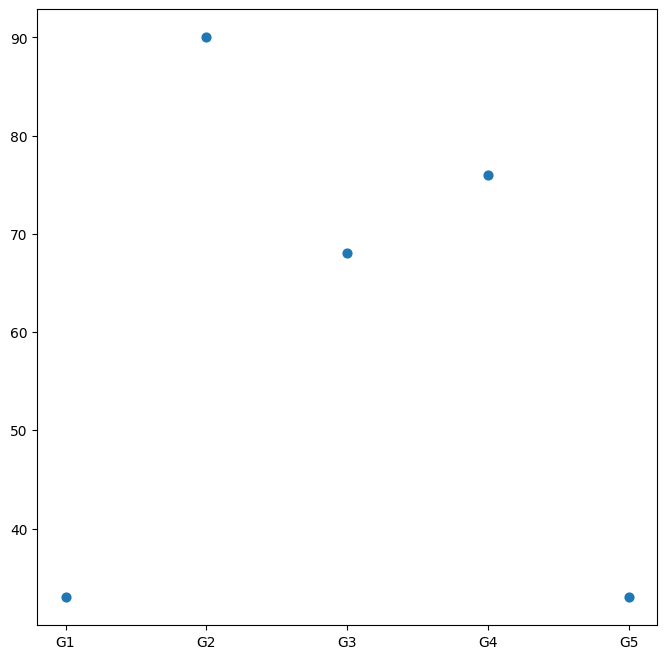

In [ ]:
plt.figure(figsize=(8,8))
Y=[pyo.value(instance.Pg[g]) for g in instance.g]
X=[g for g in instance.g]
plt.scatter(X, Y, s=40)